In [19]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


model_path = "/content/detr_finetuned_on_Cars.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


state_dict = torch.load(model_path, map_location=device)

# Set num of objects as per the training data.
num_labels = 6

print(f"Detected {num_labels} labels from the fine-tuned model.")

# Define label mappings as per the data.
id2label = {
        0: "vehicles-and-traffic-signals",
        1: "bus",
        2: "car",
        3: "person",
        4: "traffic signal",
        5: "truck"
    }
label2id = {v: k for k, v in id2label.items()}


processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Load the base model with correct `num_labels`
car_model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=num_labels,  # Set correct number of labels dynamically
    ignore_mismatched_sizes=True
).to(device)

# Fix key mismatches if necessary
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}  # Remove "model." prefix if needed

# Load the modified state_dict
car_model.load_state_dict(new_state_dict, strict=False)  # Use strict=False to allow key mismatches
car_model.eval()  # Set model to evaluation mode

# Assign label mappings
car_model.config.id2label = id2label
car_model.config.label2id = label2id

print("Model successfully loaded and ready for inference!")

<ipython-input-19-37c8a79ce66a>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Detected 6 labels from the fine-tuned model.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Model successfully loaded and ready for inference!


In [20]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def Detect_Objects(model,image_path):
  model=model
  # Load an image
  image_path = image_path
  image = Image.open(image_path).convert("RGB")

  # Ensure model and processor are on the correct device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Preprocess the image
  inputs = processor(images=image, return_tensors="pt").to(device)

  # Inference
  with torch.no_grad():
      outputs = model(**inputs)

  # Post-process the results
  target_sizes = [(image.size[1], image.size[0])]  # (height, width)
  results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.45)[0]

  # Ensure `id2label` is correctly defined
  id2label = model.config.id2label  # Get label mappings from model config

  # Draw bounding boxes on the image
  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()  # Load a default font for annotations

  # Display results
  detected_objects = []
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      label_name = id2label.get(label.item(), f"Unknown_{label.item()}")  # Handle missing labels safely
      detected_objects.append(label_name)

      # Convert tensor to list
      box = box.tolist()
      x_min, y_min, x_max, y_max = box

      # Draw rectangle
      draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

      # Display label & confidence score
      text = f"{label_name} ({score.item():.2f})"
      text_position = (x_min, y_min - 10)
      draw.text(text_position, text, fill="red", font=font)

  # Output the detected object labels
  print("Detected Objects:", detected_objects)

  # Show the image with bounding boxes
  plt.figure(figsize=(10, 8))
  plt.imshow(image)
  plt.axis("off")
  plt.show()

Detected Objects: ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']


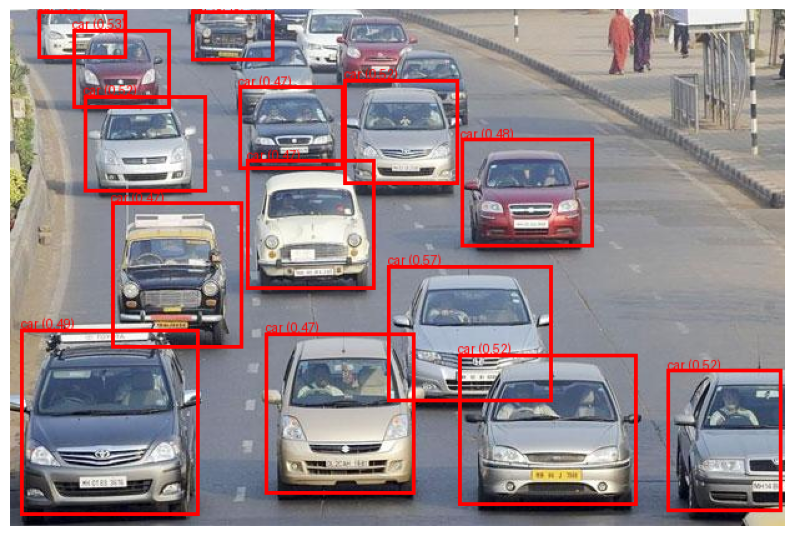

In [21]:
Detect_Objects(car_model,"/content/Road621.jpg")

Detected Objects: ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']


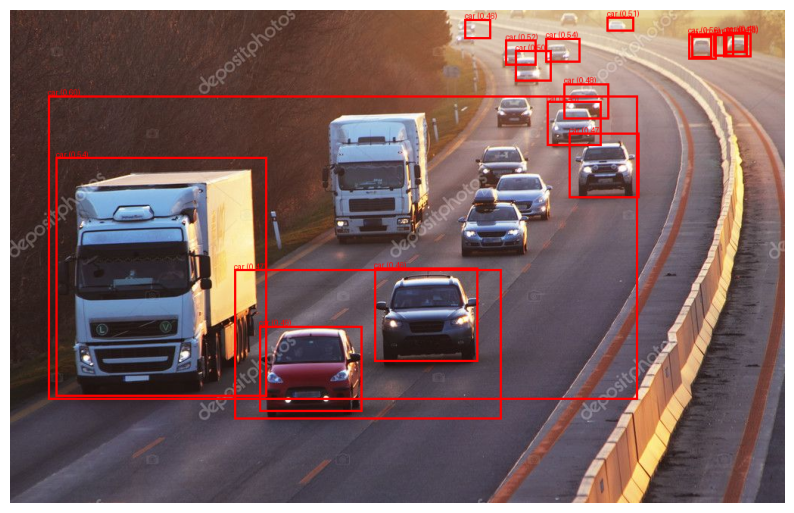

In [23]:
Detect_Objects(car_model, "/content/depositphotos_42659803-stock-photo-highway-with-cars-and-truck.jpg")

In [34]:
!wget -q https://thumbs.dreamstime.com/b/ashok-leyland-bagmati-province-nepal-july-heavy-indian-truck-interurban-road-himalaya-mountains-329938309.jpg

Detected Objects: ['car', 'car', 'car', 'car']


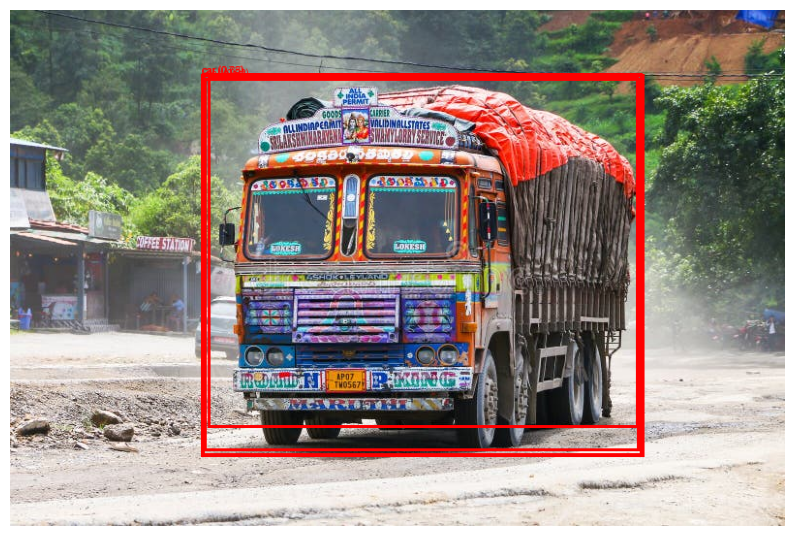

In [35]:
Detect_Objects(car_model, "/content/ashok-leyland-bagmati-province-nepal-july-heavy-indian-truck-interurban-road-himalaya-mountains-329938309.jpg")